In [47]:
import requests
import json
import pandas as pd
import os
from dotenv import load_dotenv
load_dotenv()
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler



In [48]:
should_download_data = False

# Get Games
Fetch games and their id's for multiple months to collect data

In [49]:
# Set common variables
api_key = os.environ['SPORTRADAR_API_KEY']
access_level = 'trial'
version = 'v8'
language_code = 'en'
season_year = '2022'

In [50]:
if should_download_data:
    season_schedule = f"https://api.sportradar.com/nba/{access_level}/{version}/{language_code}/games/{season_year}/REG/schedule.json?api_key={api_key}"
    response = requests.get(season_schedule)
    if response.status_code == 200:
        try:
            schedule_data = response.json()
        except ValueError as e:
            print("Error decoding JSON:", e)
    else:
        print("Failed to retrieve data: ", response.status_code)
    schedule_data = response.json()
    print(json.dumps(schedule_data, indent=4, sort_keys=True))

In [51]:
if should_download_data: 
    with (open("data/season_schedule.json", "w")) as f:
        json.dump(schedule_data, f, indent=4)

In [52]:
# Open the file
with open("data/season_schedule.json", "r") as f:
    schedule_data = json.load(f)

flat_data = schedule_data['games']

df = pd.DataFrame(flat_data)
df["target"] = df["home_points"] > df["away_points"]
df.head()

,id,status,coverage,scheduled,home_points,away_points,track_on_court,sr_id,reference,time_zones,venue,broadcasts,home,away,title,neutral_site,target
0,9f01b268-29c5-4f0e-bf67-21e3dbcf3005,closed,full,2022-10-18T23:30:00Z,126.0,117.0,True,sr:match:35431579,0022200001,"{'venue': 'US/Eastern', 'home': 'US/Eastern', ...","{'id': '7d69b080-91ca-53c9-9302-45c1a72c5549',...","[{'network': 'TNT', 'type': 'TV', 'locale': 'N...","{'name': 'Boston Celtics', 'alias': 'BOS', 'id...","{'name': 'Philadelphia 76ers', 'alias': 'PHI',...",NaN,NaN,True
1,c665e441-9f38-48a7-8796-1f7292f97db1,closed,full,2022-10-19T02:00:00Z,123.0,109.0,True,sr:match:35431587,0022200002,"{'venue': 'US/Pacific', 'home': 'US/Pacific', ...","{'id': '938016dc-9e1d-4abc-88f5-3a7d772332e6',...","[{'network': 'TNT', 'type': 'TV', 'locale': 'N...","{'name': 'Golden State Warriors', 'alias': 'GS...","{'name': 'Los Angeles Lakers', 'alias': 'LAL',...",NaN,NaN,True
2,1f8105fe-e6ca-475f-aea6-15b455892a9e,closed,full,2022-10-19T23:00:00Z,107.0,114.0,True,sr:match:35431591,0022200004,"{'venue': 'US/Eastern', 'home': 'US/Eastern', ...","{'id': '24bb478e-eb31-5f8a-8c8d-07f513169ec1',...","[{'network': 'NBCS-DC', 'type': 'TV', 'locale'...","{'name': 'Indiana Pacers', 'alias': 'IND', 'id...","{'name': 'Washington Wizards', 'alias': 'WAS',...",NaN,NaN,False
3,9f64a3b0-46bd-4caa-b5c3-4578e9bab8d8,closed,full,2022-10-19T23:00:00Z,113.0,109.0,True,sr:match:35431589,0022200003,"{'venue': 'US/Eastern', 'home': 'US/Eastern', ...","{'id': '5a9ddefc-2267-4fd1-8d6e-0f82163ce8bd',...","[{'network': 'BSDET', 'type': 'TV', 'locale': ...","{'name': 'Detroit Pistons', 'alias': 'DET', 'i...","{'name': 'Orlando Magic', 'alias': 'ORL', 'id'...",NaN,NaN,True
4,44b31f4a-bc51-41aa-b1d9-a2bfc95d4e0d,closed,full,2022-10-19T23:30:00Z,108.0,105.0,True,sr:match:35431599,0022200008,"{'venue': 'US/Eastern', 'home': 'US/Eastern', ...","{'id': '62cc9661-7b13-56e7-bf4a-bba7ad7be8da',...","[{'network': 'BSOH', 'type': 'TV', 'locale': '...","{'name': 'Toronto Raptors', 'alias': 'TOR', 'i...","{'name': 'Cleveland Cavaliers', 'alias': 'CLE'...",NaN,NaN,True


In [53]:
if should_download_data:

    from concurrent.futures import ThreadPoolExecutor, as_completed
    from tqdm import tqdm

    def get_play_by_play(game_id):
        url = f"https://api.sportradar.com/nba/{access_level}/{version}/{language_code}/games/{game_id}/pbp.json?api_key={api_key}"
        response = requests.get(url)
        if response.status_code == 200:
            try:
                return response.json()
            except ValueError as e:
                print("Error decoding JSON:", e)
        else:
            print("Failed to retrieve data: ", response.status_code)
        return None

    game_ids = [game['id'] for game in schedule_data['games']]

    play_by_play_data = []
    with ThreadPoolExecutor(max_workers=5) as executor:
        future_to_game_id = {executor.submit(get_play_by_play, game_id): game_id for game_id in game_ids}
        for future in tqdm(as_completed(future_to_game_id), total=len(game_ids)):
            data = future.result()
            if data is not None:
                play_by_play_data.append(data)

    with open("data/play_by_play_data.json", "w") as f:
        json.dump(play_by_play_data, f, indent=4)

In [54]:
# Get data from the json file and put it into a dataframe

with open('data/play_by_play_data.json') as f:
    data = json.load(f)


# Feature Engineering

In [55]:
game_level_data_copy = df.copy()

df = pd.DataFrame(data)
df.head()

,id,status,coverage,scheduled,duration,attendance,lead_changes,times_tied,clock,quarter,track_on_court,reference,entry_mode,sr_id,clock_decimal,time_zones,home,away,periods,deleted_events,title,neutral_site
0,44b31f4a-bc51-41aa-b1d9-a2bfc95d4e0d,closed,full,2022-10-19T23:30:00+00:00,2:19,19800.0,16.0,17.0,00:00,4.0,True,0022200008,WEBSOCKET,sr:match:35431599,00:00,"{'venue': 'US/Eastern', 'home': 'US/Eastern', ...","{'name': 'Raptors', 'alias': 'TOR', 'market': ...","{'name': 'Cavaliers', 'alias': 'CLE', 'market'...","[{'type': 'quarter', 'id': '08bea6a0-f82a-41a9...",[{'id': '16d692db-a7a7-43fc-9535-a3187cd349ab'...,NaN,NaN
1,9f01b268-29c5-4f0e-bf67-21e3dbcf3005,closed,full,2022-10-18T23:30:00+00:00,2:31,19156.0,8.0,7.0,00:00,4.0,True,0022200001,WEBSOCKET,sr:match:35431579,00:00,"{'venue': 'US/Eastern', 'home': 'US/Eastern', ...","{'name': 'Celtics', 'alias': 'BOS', 'market': ...","{'name': '76ers', 'alias': 'PHI', 'market': 'P...","[{'type': 'quarter', 'id': 'b2055122-2475-4178...",[{'id': '3a7522fd-dd18-4644-aa0f-fb8294b65c84'...,NaN,NaN
2,9f64a3b0-46bd-4caa-b5c3-4578e9bab8d8,closed,full,2022-10-19T23:00:00+00:00,2:16,20190.0,7.0,4.0,00:00,4.0,True,0022200003,WEBSOCKET,sr:match:35431589,00:00,"{'venue': 'US/Eastern', 'home': 'US/Eastern', ...","{'name': 'Pistons', 'alias': 'DET', 'market': ...","{'name': 'Magic', 'alias': 'ORL', 'market': 'O...","[{'type': 'quarter', 'id': 'f2bf467f-85da-4a05...",[{'id': '50061ec0-25f9-4ab2-af46-8867d9565cc0'...,NaN,NaN
3,c665e441-9f38-48a7-8796-1f7292f97db1,closed,full,2022-10-19T02:00:00+00:00,2:33,18064.0,1.0,2.0,00:00,4.0,True,0022200002,WEBSOCKET,sr:match:35431587,00:00,"{'venue': 'US/Pacific', 'home': 'US/Pacific', ...","{'name': 'Warriors', 'alias': 'GSW', 'market':...","{'name': 'Lakers', 'alias': 'LAL', 'market': '...","[{'type': 'quarter', 'id': '30829330-c8e3-4ff6...",[{'id': '625bb81a-0ede-4a8e-8f16-4cc5cc2704ad'...,NaN,NaN
4,1f8105fe-e6ca-475f-aea6-15b455892a9e,closed,full,2022-10-19T23:00:00+00:00,2:22,15027.0,0.0,0.0,00:00,4.0,True,0022200004,WEBSOCKET,sr:match:35431591,00:00,"{'venue': 'US/Eastern', 'home': 'US/Eastern', ...","{'name': 'Pacers', 'alias': 'IND', 'market': '...","{'name': 'Wizards', 'alias': 'WAS', 'market': ...","[{'type': 'quarter', 'id': 'e5c8501a-729a-4746...",[{'id': 'c36853e2-f892-42f7-a482-2bf4209d139a'...,NaN,NaN


## Function Declarations

In [119]:
def process_data(df):
    df_copy = df.copy()

    # List of columns to drop initially
    columns_to_drop = ["lead_changes", "times_tied", "track_on_court", "deleted_events", 'coverage', 'scheduled', "status", "attendance", "clock", "duration", "reference", "entry_mode", "sr_id", "clock_decimal", "time_zones", "quarter"]
    # List of team features to drop
    team_features_to_drop = ["name", "alias", "market", "id", "sr_id", "bonus", "remaining_timeouts", "reference", "points"]

    # Process home and away data
    for team in ['home', 'away']:
        team_data = pd.json_normalize(df_copy[team]).drop(team_features_to_drop, axis=1, inplace=False)
        team_data.columns = [f'{team}_{col}' for col in team_data.columns]
        df_copy = df_copy.join(team_data)

    # Create features for home win percentage and away win percentage based on the team's record
    for team in ['home', 'away']:
        df_copy[f'{team}_win_pct'] = df_copy[f"{team}_record.wins"] / (df_copy[f"{team}_record.wins"] + df_copy[f"{team}_record.losses"])
        columns_to_drop.extend([f"{team}_record.wins", f"{team}_record.losses"])

    # Drop the home, away and record columns from the original dataframe
    columns_to_drop.extend(["home", "away"])
    df_copy["target"] = game_level_data_copy["target"]

    df_copy.drop(columns_to_drop, axis=1, inplace=True)

    return df_copy

In [160]:
import pandas as pd

def extract_periods(df):
    # Create an empty DataFrame to store the extracted data
    extracted_data = pd.DataFrame()

    features_to_keep = ['game_id','type', 'id', 'number', 'sequence', 'times_tied',
       'lead_changes', "events","home_win_pct", "away_win_pct", "target"]

    for i in range(len(df)):
        # Iterate through each game entry
        game_id = df['id'].iloc[i]
        periods = df['periods'].iloc[i]
        target = df['target'].iloc[i]
        home_win_pct = df['home_win_pct'].iloc[i]
        away_win_pct = df['away_win_pct'].iloc[i]

        for period in periods:
            # For each period, flatten the period data and the nested 'scoring' data
            period_data = pd.json_normalize(period)
            scoring_data = pd.json_normalize(period['scoring'])

            # Combine period data with scoring data
            combined_data = pd.concat([period_data, scoring_data], axis=1)

            # Add game-level information (e.g., game ID)
            combined_data['game_id'] = game_id
            combined_data['target'] = target
            combined_data['home_win_pct'] = home_win_pct
            combined_data['away_win_pct'] = away_win_pct
            # If times_tied doesn't exist, fill it with 0
            if 'times_tied' not in combined_data.columns:
                combined_data['times_tied'] = 0

            # Append to the extracted_data DataFrame
            extracted_data = pd.concat([extracted_data, combined_data], ignore_index=True)

    # Keep only the columns we want
    extracted_data = extracted_data[features_to_keep]

    return extracted_data

In [121]:
from enum import Enum
import numpy as np
from tqdm import tqdm
from collections import deque

class Team(Enum):
    HOME = 1
    AWAY = 0
    TIED = -1


def convert_to_timedelta(time_str):
    if '.' in time_str:
        # Format '00:ss.ms'
        minutes = '00'
        seconds, milliseconds = time_str.split('.')
        seconds = seconds.zfill(2)  # Ensure two digits in seconds
        time_formatted = f'{minutes}:{seconds}.{milliseconds}'
    else:
        # Format 'mm:ss'
        minutes, seconds = time_str.split(':')
        minutes = minutes.zfill(2)  # Ensure two digits in minutes
        time_formatted = f'00:{minutes}:{seconds}'

    return pd.to_timedelta(time_formatted)

def calculate_game_time_remaining(quarter_number, clock_decimal):
    try:
        total_time_per_quarter = pd.to_timedelta('00:12:00')
        overtime_time_per_quarter = pd.to_timedelta('00:05:00')

        game_time_remaining = np.where(quarter_number <= 4,
                                       (4 - quarter_number) * total_time_per_quarter + clock_decimal,
                                       (5 - quarter_number) * overtime_time_per_quarter + clock_decimal)

        # Convert game_time_remaining to seconds
        game_time_remaining_seconds = game_time_remaining / np.timedelta64(1, 's')

        return game_time_remaining_seconds
    except OverflowError as e:
        print(f"Error processing sequence {quarter_number}, clock_decimal {clock_decimal}: {e}")
        return pd.NaT
    
def calculate_scoring_run(recent_scoring, max_window_size=25):
    current_window_size = min(len(recent_scoring), max_window_size)
    if current_window_size > 0:  # Ensure at least one event is in the window
        recent_list = list(recent_scoring)  # Convert deque to list for slicing
        return max(recent_list[-current_window_size:]) - min(recent_list[-current_window_size:])
    return 0  # Default value if no events yet



def encode_leading_team(row):
    if pd.isna(row['current_leading_team_id']):
        return Team.TIED.value  # Tie
    elif row['current_leading_team_id'] == row['on_court.away.id']:
        return Team.AWAY.value  # Away team leads
    else:
        return Team.HOME.value  # Home team leads

In [141]:
import time

def extract_events(df): 
    start_time = time.time()
    extracted_data_frame = pd.DataFrame()
    print(df["home_win_pct"].iloc[0])

    CLOSE_GAME_THRESHOLD = 5
    CRITICAL_TIME_THRESHOLD = 300
    # RECENT_EVENTS_WINDOW = 25 # Number of events to keep in the recent scoring deque

    last_known_leading_team = None
    previous_score_difference = None
    lead_change_count = 0
    times_tied_count = 0
    # recent_scoring = deque(maxlen=RECENT_EVENTS_WINDOW)

    # Apply normalization and standardization
    # Initialize scalers
    minmax_scaler = MinMaxScaler()
    standard_scaler = StandardScaler()

    # Normalize and standardize
    features_to_normalize = ['game_time_remaining']
    features_to_standardize = ['home_points', 'away_points', 'current_score_difference', 'lead_changes', 'times_tied']

    win_pct_dict = {}

    all_events = []


    # Add tqdm() around the range to create a progress bar
    for i in tqdm(range(len(df))):
        loop_start_time = time.time()

        game_id = df['game_id'].iloc[i]
        events = df['events'].iloc[i]
        quarter_number = df['sequence'].iloc[i]
       
        # Drop event_type column
        

        events = [event for event in events if event['event_type'] != 'endperiod']
        events = [event for event in events if event['event_type'] not in ['lineupchange', 'timeout', 'endtimeout', "teamtimeout", "flagrantone", "flagranttwo", "stoppage", "opentip", "delay", "jumpball", "review", "kickball", "jumpballviolation", "doublelane", "ejection"]]

        if game_id in win_pct_dict:
            print("Game ID found in dictionary")
            home_win_pct, away_win_pct, target = win_pct_dict[game_id]
        else:
            print("Game ID not found in dictionary")
            home_win_pct = df['home_win_pct'].iloc[i]
            away_win_pct = df['away_win_pct'].iloc[i]
            target = df['target'].iloc[i]
            win_pct_dict[game_id] = (home_win_pct, away_win_pct, target)

        event_loop_start_time = time.time()        
        normalize_total_diff = 0
        for event in events:    
            event_data = pd.json_normalize(event)
            event_data['game_id'] = game_id
            event_data["quarter_number"] = quarter_number
            event_data.drop(['event_type'], axis=1, inplace=True)
            if 'possession.id' not in event_data.columns:
                event_data['possession.id'] = None


            # Time remaining in game feature
            event_data['clock_decimal'] = event_data['clock_decimal'].apply(convert_to_timedelta)
            event_data['game_time_remaining'] = calculate_game_time_remaining(event_data['quarter_number'], event_data['clock_decimal'])
            event_data["current_score_difference"] = event_data["home_points"] - event_data["away_points"];
            event_data["current_leading_team_id"] = np.where(event_data["current_score_difference"] > 0, event_data["on_court.home.id"], np.where(event_data["current_score_difference"] < 0, event_data["on_court.away.id"], None))            
            current_score_difference = event_data["current_score_difference"].iloc[0]

            # Determine the current leading team
            if current_score_difference > 0:
                current_leading_team = Team.HOME.value
            elif current_score_difference < 0:
                current_leading_team = Team.AWAY.value
            else:
                current_leading_team = Team.TIED.value

            # Update lead change count
            if last_known_leading_team is not None and last_known_leading_team != Team.TIED and current_leading_team != Team.TIED and current_leading_team != last_known_leading_team:
                lead_change_count += 1

            if current_leading_team != Team.TIED:
                last_known_leading_team = current_leading_team
            # Add lead change count and times tied count to the DataFrame
            event_data['lead_changes'] = lead_change_count
            
            # Update times tied
            if previous_score_difference is not None and previous_score_difference != 0 and current_score_difference == 0:
                times_tied_count += 1
            previous_score_difference = current_score_difference
            event_data['times_tied'] = times_tied_count

            
            # # Recent scoring
            # recent_scoring.append(current_score_difference)
            # event_data['scoring_run'] = calculate_scoring_run(recent_scoring)
                        
            event_data['is_close_game'] = event_data['current_score_difference'].abs() <= CLOSE_GAME_THRESHOLD & (event_data['game_time_remaining'] <= CRITICAL_TIME_THRESHOLD)
            
            try:
                event_data['critical_possession'] = event_data['is_close_game'] & (event_data['game_time_remaining'] <= CRITICAL_TIME_THRESHOLD) & (event_data['possession.id'] == event_data['current_leading_team_id'])
            except KeyError: 
                event_data['critical_possession'] = False

            # Pre-computed values
            event_data['home_win_pct'] = home_win_pct
            event_data['away_win_pct'] = away_win_pct
            event_data["target"] = target
            
            event_data['home_possession'] = (event_data['possession.id'] == event_data['on_court.home.id']).astype(int)
            event_data['away_possession'] = (event_data['possession.id'] == event_data['on_court.away.id']).astype(int)
            event_data['no_possession'] = event_data['possession.id'].isna().astype(int)

            event_data['encoded_leading_team'] = event_data.apply(encode_leading_team, axis=1)


            event_data.drop(['clock_decimal'], axis=1, inplace=True)

            all_events.append(event_data)

        event_loop_end_time = time.time()

        # Concatenate all DataFrames in the list
        loop_end_time = time.time()
        # print(f"Time taken for loop iteration {i}: {loop_end_time - loop_start_time} seconds")
        # print(f"Time taken for event loop iteration {i}: {event_loop_end_time - event_loop_start_time} seconds")
        # Percentage of time the event loop took compared to the total time
        # print(f"Percentage of time the event loop took compared to the total time: {(event_loop_end_time - event_loop_start_time) / (loop_end_time - loop_start_time)}")

    concat_start_time = time.time()
    extracted_data_frame = pd.concat(all_events, ignore_index=True)
    concat_end_time = time.time()
    print(f"Time taken for concatenation: {concat_end_time - concat_start_time} seconds")

    normalization_start_time = time.time()

    extracted_data_frame[features_to_normalize] = minmax_scaler.fit_transform(extracted_data_frame[features_to_normalize])
    # Apply standardization
    extracted_data_frame[features_to_standardize] = standard_scaler.fit_transform(extracted_data_frame[features_to_standardize])
    normalization_end_time = time.time()
    normalize_total_diff += (normalization_end_time - normalization_start_time)
    print(f"Time taken for normalization: {normalization_end_time - normalization_start_time} seconds")

    features_to_keep = ['home_points', 'away_points', "quarter_number",
         "game_time_remaining", "current_score_difference", "is_close_game", "critical_possession",
         'lead_changes', 'times_tied', "home_win_pct", "away_win_pct", "target", "home_possession", "away_possession", "no_possession", "encoded_leading_team" ]
    # features_to_add_later = ["on_court.home.players", "on_court.away.players", "statistics", "attempt"]
    extracted_data = extracted_data_frame[features_to_keep]
    end_time = time.time()
    print(f"Total time taken: {end_time - start_time} seconds")
    print(f"Percentage of time the concatenation took compared to the total time: {(concat_end_time - concat_start_time) / (end_time - start_time)}")
    print(f"Percentage of time the normalize took compared to the total time: {normalize_total_diff / (end_time - start_time)}")
    return extracted_data



## Feature Extraction

### Process play-by-play data

In [123]:
df_processed = process_data(df)
df_processed.head()

,id,periods,home_win_pct,away_win_pct,target
0,7080e67e-8bcb-46f1-981a-0d67d4d0615b,"[{'type': 'quarter', 'id': '21518ade-20a0-44f2...",0.538462,0.16,True


### Process period data

In [124]:
# Use the function to extract period data
period_data = extract_periods(df_processed)
# Display the first few rows
period_data.head()

,game_id,type,id,number,sequence,times_tied,lead_changes,events,home_win_pct,away_win_pct,target
0,7080e67e-8bcb-46f1-981a-0d67d4d0615b,quarter,21518ade-20a0-44f2-993e-ce008e767065,1,1,0,5,[{'id': 'f61d951e-9aa4-4390-91b3-95414e5ffd83'...,0.538462,0.16,True
1,7080e67e-8bcb-46f1-981a-0d67d4d0615b,quarter,746d24bb-f46f-4a19-95b1-87ea8425300f,2,2,0,0,[{'id': '1a61c5ac-2131-411a-b219-f5764d5002e0'...,0.538462,0.16,True
2,7080e67e-8bcb-46f1-981a-0d67d4d0615b,quarter,b2d5cf44-6129-4c77-a65c-a0c6920bffee,3,3,0,0,[{'id': '1566227f-f8af-476d-a284-f5160d434437'...,0.538462,0.16,True
3,7080e67e-8bcb-46f1-981a-0d67d4d0615b,quarter,a59e87cf-4b80-4c5c-a3b4-70a87ed1ab53,4,4,1,3,[{'id': 'e1cc364f-7cae-4021-89e5-ba25180f2c84'...,0.538462,0.16,True


In [58]:
# Store the data in a CSV file
# period_data.to_csv('data/period_data.csv', index=False)

### Process event-level data

In [144]:
event_data = extract_events(period_data)

0.5384615384615384


  0%|          | 0/4 [00:00<?, ?it/s]

Game ID not found in dictionary


 50%|█████     | 2/4 [00:00<00:00,  3.86it/s]

Game ID found in dictionary
Game ID found in dictionary


100%|██████████| 4/4 [00:01<00:00,  3.56it/s]

Game ID found in dictionary
Time taken for concatenation: 0.08511900901794434 seconds
Time taken for normalization: 0.0057141780853271484 seconds
Total time taken: 1.2199406623840332 seconds
Percentage of time the concatenation took compared to the total time: 0.06977307310308274
Percentage of time the normalize took compared to the total time: 0.004683980345536138


In [145]:
event_data.head()

,home_points,away_points,quarter_number,game_time_remaining,current_score_difference,is_close_game,critical_possession,lead_changes,times_tied,home_win_pct,away_win_pct,target,home_possession,away_possession,no_possession,encoded_leading_team
0,-1.532939,-1.894579,1,1.000000,1.287816,False,False,-2.634061,-0.497783,0.538462,0.16,True,0,1,0,1
1,-1.532939,-1.894579,1,0.993718,1.287816,False,False,-2.634061,-0.497783,0.538462,0.16,True,0,0,1,1
2,-1.532939,-1.894579,1,0.992322,1.287816,False,False,-2.634061,-0.497783,0.538462,0.16,True,1,0,0,1
3,-1.532939,-1.894579,1,0.991973,1.287816,False,False,-2.634061,-0.497783,0.538462,0.16,True,0,1,0,1
4,-1.532939,-1.894579,1,0.988484,1.287816,False,False,-2.634061,-0.497783,0.538462,0.16,True,0,0,1,1


In [61]:
# event_data.to_csv("data/event_data.csv", index=False)

In [63]:
# Display head for the where event_type_delay is true 
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 10)
# Drop id and game id
event_data.head(30)




,home_points,away_points,quarter_number,game_time_remaining,current_score_difference,is_close_game,critical_possession,lead_changes,times_tied,home_win_pct,away_win_pct,target,home_possession,away_possession,no_possession,encoded_leading_team
0,-1.707242,-1.697814,1,0.993082,-0.127137,True,False,-1.711267,-1.723643,0.464286,0.578544,True,0,0,1,-1
1,-1.707242,-1.697814,1,0.992138,-0.127137,True,False,-1.711267,-1.723643,0.464286,0.578544,True,1,0,0,-1
2,-1.707242,-1.697814,1,0.988364,-0.127137,True,False,-1.711267,-1.723643,0.464286,0.578544,True,0,0,1,-1
3,-1.707242,-1.697814,1,0.987421,-0.127137,True,False,-1.711267,-1.723643,0.464286,0.578544,True,1,0,0,-1
4,-1.649564,-1.697814,1,0.987107,0.056818,False,False,-1.711096,-1.723643,0.464286,0.578544,True,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,-1.563048,-1.580353,1,0.940564,-0.035159,False,False,-1.710414,-1.723162,0.464286,0.578544,True,0,1,0,1
26,-1.563048,-1.580353,1,0.938992,-0.035159,False,False,-1.710414,-1.723162,0.464286,0.578544,True,1,0,0,1
27,-1.476531,-1.580353,1,0.937419,0.240773,False,False,-1.710414,-1.723162,0.464286,0.578544,True,0,1,0,1
28,-1.476531,-1.580353,1,0.934904,0.240773,False,False,-1.710414,-1.723162,0.464286,0.578544,True,1,0,0,1


# Modelling

In [64]:
from sklearn.model_selection import train_test_split

# Drop data that has NaN values
event_data.dropna(inplace=True)

X = event_data.drop(['target'], axis=1)  # Features
y = event_data['target']               # Target variable


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Logistic Regression

In [65]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Implement logistic regression with class balancing 
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)


y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.70431D+05    |proj g|=  6.02281D+04

At iterate   50    f=  2.39173D+05    |proj g|=  4.51381D+02

At iterate  100    f=  2.39160D+05    |proj g|=  2.30899D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16    100    111      1     0     0   2.309D+01   2.392D+05
  F =   239160.43610471877     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', verbose=1)

### Cross Validation

In [67]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X, y, cv=5)
print("Cross-validated scores:", scores)


### Feature Importance Analysis

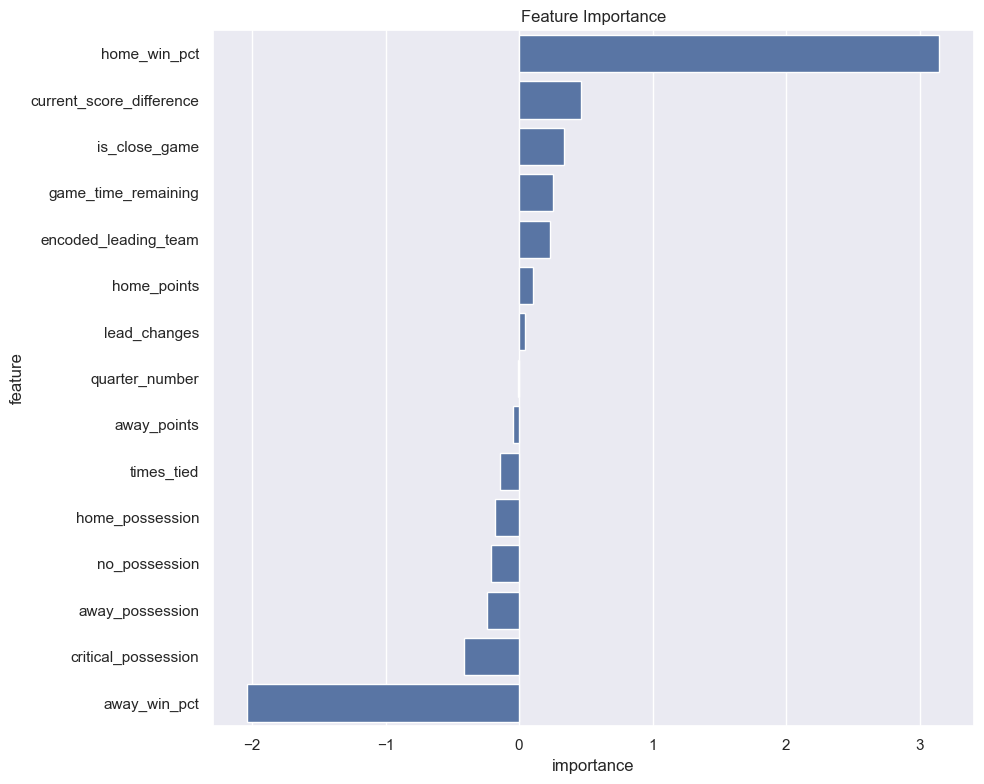

In [68]:
# Feature importance analysis
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Get feature importance from the model
feature_importance = pd.DataFrame(list(zip(X.columns, model.coef_[0])), columns=['feature', 'importance'])
feature_importance.sort_values(by='importance', ascending=False, inplace=True)

# Plot the feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

### Hyperparameter tuning

In [69]:
# # Implement GridSearchCV for hyperparameter tuning

# from sklearn.model_selection import GridSearchCV

# # Create regularization penalty space
# penalty = ['l1', 'l2']

# # Create regularization hyperparameter space
# C = np.logspace(0, 4, 10)

# # Create hyperparameter options
# hyperparameters = dict(C=C, penalty=penalty)

# # Create grid search using 5-fold cross validation
# clf = GridSearchCV(model, hyperparameters, cv=5)

# # Fit grid search
# best_model = clf.fit(X_train, y_train)

# # View best hyperparameters
# print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
# print('Best C:', best_model.best_estimator_.get_params()['C'])


### Single Game Win Probability Calculation

0.5555555555555556


  0%|          | 0/5 [00:00<?, ?it/s]

Game ID not found in dictionary


 20%|██        | 1/5 [00:00<00:01,  3.83it/s]

Game ID found in dictionary


 40%|████      | 2/5 [00:00<00:00,  3.55it/s]

Game ID found in dictionary


 80%|████████  | 4/5 [00:01<00:00,  3.24it/s]

Game ID found in dictionary
Game ID found in dictionary


100%|██████████| 5/5 [00:01<00:00,  3.69it/s]


Time taken for concatenation: 0.12366294860839844 seconds
Time taken for normalization: 0.0025010108947753906 seconds
Total time taken: 1.4810521602630615 seconds
Percentage of time the concatenation took compared to the total time: 0.08349668696775249
Percentage of time the normalize took compared to the total time: 0.001688671717227816
0      1
1      1
2      1
3      1
4      1
      ..
461    5
462    5
463    5
464    5
465    5
Name: quarter_number, Length: 466, dtype: int64


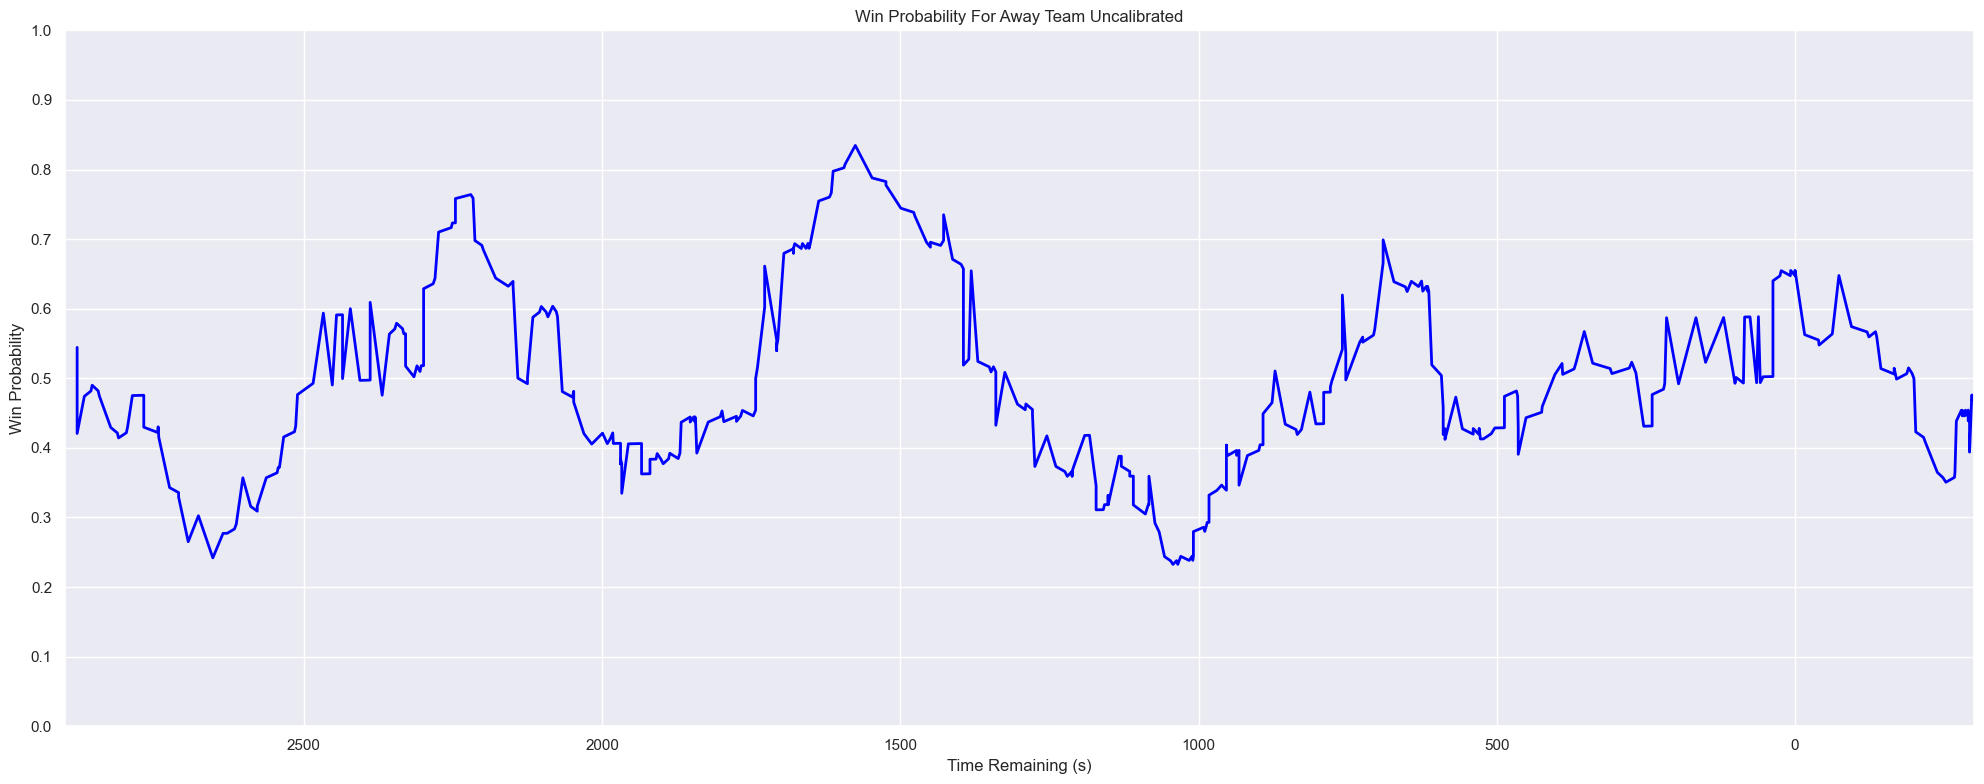

home_points                 1.312561
away_points                 1.408787
quarter_number                     4
game_time_remaining         0.012863
current_score_difference   -0.615607
                              ...   
home_possession                    0
away_possession                    1
no_possession                      0
encoded_leading_team               1
adjusted_time_remaining     0.012863
Name: 414, Length: 17, dtype: object


In [222]:
# Get data from a json file, preprocess it and use the trained model to predict probabilities for each event

def predict_probabilities(df):
    df_processed = process_data(df)
    
    period_data = extract_periods(df_processed)
    

    event_data = extract_events(period_data)
    event_data.dropna(inplace=True)
    return event_data

# Open the file
with open("data/clehou181223.json", "r") as f:
    data = json.load(f)

df = pd.DataFrame(data)

# Get the probabilities for each event
event_data = predict_probabilities(df)

# Adjust this based on the length of one overtime period in seconds
overtime_length = 5 * 60

# Function to calculate time remaining including overtime
def calc_time_remaining(row):
    if row['quarter_number'] <= 4:
        return row['game_time_remaining']
    elif row['quarter_number'] > 4:
        # Adjust for overtime: add the duration of each overtime period that has passed
        overtime_periods = row['quarter_number'] - 4
        return row['game_time_remaining'] -  0.10416666666666667 * overtime_periods
    else:
        pass

# Apply this function to each row
event_data['adjusted_time_remaining'] = event_data.apply(calc_time_remaining, axis=1)


# period_data.head()

X = event_data.drop(['target', "adjusted_time_remaining"], axis=1)  # Features
y = event_data['target']            # Target variable
win_probabilities = model.predict_proba(X)

win_probabilities = win_probabilities[:, 0]  # Adjust based on your class of interest

# Print the quarter numbers of the events
print(event_data['quarter_number'])

# # Plot the win probabilities where x is the seconds remaining in the game and y is the win probability for the home team
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plt.figure(figsize=(20, 8))
# y axis is between 0 and 1, and shows it in increments of 0.1
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylim(0, 1)
# x axis is between 0 and 2880

max_quarter_number = event_data['quarter_number'].max() - 4

plt.plot(event_data['adjusted_time_remaining'] * 2880, win_probabilities, color='blue', linewidth=2)

plt.title('Win Probability For Away Team Uncalibrated')
plt.xlabel('Time Remaining (s)')
plt.ylabel('Win Probability')
plt.gca().invert_xaxis()  # Reverse the x-axis
plt.xlim(2900, -300 * max_quarter_number)
plt.tight_layout()
plt.show()

# Calculate the differences between consecutive win probabilities
diffs = np.diff(win_probabilities)

# Find the index of the largest jump
largest_jump_index = np.argmax(diffs)

# Get the event that caused the largest jump
event = event_data.iloc[largest_jump_index]

print(event)



In [165]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression

# Train the logistic regression model
lr = LogisticRegression()
lr.fit(X_train, y_train)

# Calibrate the model
calibrated = CalibratedClassifierCV(lr, method='sigmoid', cv=5)
calibrated.fit(X_train, y_train)

# Now you can use `calibrated` to make predictions
win_probabilities = calibrated.predict_proba(X)

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

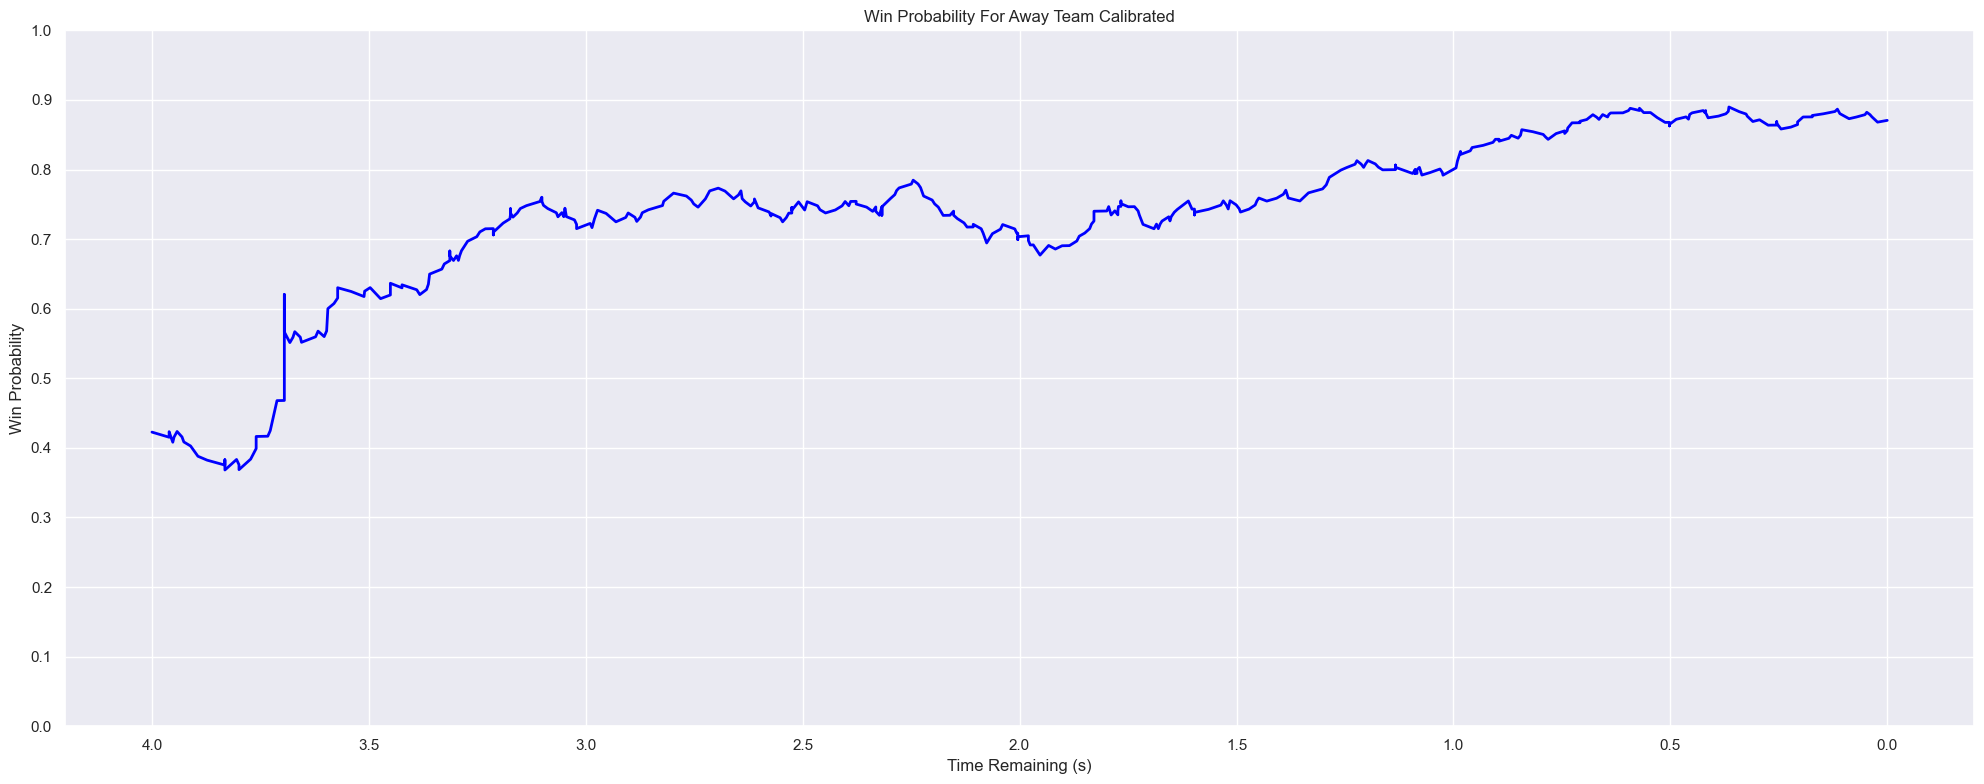

home_points                -1.420964
away_points                -1.467157
quarter_number                     1
game_time_remaining          0.92371
current_score_difference    1.455539
                              ...   
target                          True
home_possession                    1
away_possession                    0
no_possession                      0
encoded_leading_team               0
Name: 25, Length: 16, dtype: object


In [166]:
win_probabilities = win_probabilities[:, 0]  # Adjust based on your class of interest

# # Plot the win probabilities where x is the seconds remaining in the game and y is the win probability for the home team
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plt.figure(figsize=(20, 8))
# y axis is between 0 and 1, and shows it in increments of 0.1
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylim(0, 1)

# x axis is between 0 and 2880 (48 minutes)
plt.plot(event_data['game_time_remaining'] * 2880 / 60 / 12, win_probabilities, color='blue', linewidth=2)
plt.title('Win Probability For Away Team Calibrated')
plt.xlabel('Time Remaining (s)')
plt.ylabel('Win Probability')
plt.gca().invert_xaxis()  # Reverse the x-axis
plt.tight_layout()
plt.show()

# Calculate the differences between consecutive win probabilities
diffs = np.diff(win_probabilities)

# Find the index of the largest jump
largest_jump_index = np.argmax(diffs)

# Get the event that caused the largest jump
event = event_data.iloc[largest_jump_index]

print(event)


## AdaBoost

In [ ]:
# Implement AdaBoost

from sklearn.ensemble import AdaBoostClassifier

model = AdaBoostClassifier(n_estimators=500, random_state=42, learning_rate=0.1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))


Accuracy: 0.7096003608849885
              precision    recall  f1-score   support

       False       0.69      0.56      0.62     40824
        True       0.72      0.82      0.77     56714

    accuracy                           0.71     97538
   macro avg       0.70      0.69      0.69     97538
weighted avg       0.71      0.71      0.70     97538

Cross-validated scores: [0.58461318 0.61333019 0.58838606 0.59993643 0.41866164]


### Cross validation

In [ ]:
# scores = cross_val_score(model, X, y, cv=5)
# print("Cross-validated scores:", scores)